In [1]:
import pandas as pd
import numpy as np
import requests as req
import datetime as dt
import time
from scipy.stats import norm, binom
import statsmodels.api as sm
import matplotlib.pyplot as plt

__Pet проект__. 

Данная тетрадь представляет из себя набор функций на основании которых можно составить стратегию для торгового бота

Представлены функции для загрузки данных с Московской биржи:
- Цены акции

Представлены функции для расчета:
- Расчет Value at Risk


# Загрузка данных

__Константы для функций__

In [2]:
# Определение констант 
SECID = 'SBER'
INDEXID = 'IMOEX'
END_DATE = dt.datetime.today().strftime('%Y-%m-%d') # Окно заканчивается сегодняшней ценой закрытия
START_DATE = (dt.datetime.today() - dt.timedelta(days=365)
             ).strftime('%Y-%m-%d') #Окно начинается год назад
MA_WINDOW = 90

## Загрузка данных акций

Для загрузки данных с API применяются три основные функции:
__flatten__, __get_moex_stock_data__, __get_moex_data_and_prepare__

### Описание функций

__- flatten__ используется для преобразования вложенного JSON-объекта, полученного из MOEX API, в плоский список словарей.

- **Параметры**:
  - `j` (dict): JSON-объект, полученный из MOEX API. Этот объект должен содержать блок данных с определёнными столбцами и значениями.
  - `blockname` (str): Имя ключа в JSON-объекте, который содержит необходимые данные. Обычно этот ключ указывает на блок данных, например, “history”.

__- get_moex_stock_data__ - возвращает список словарей, где каждый словарь представляет одну запись с данными о ценах акций.

- **Параметры**:
  - `secid` (str): Идентификатор ценной бумаги.
  - `start_date` (str или datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `end_date` (str или datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `engine` (str): Движок рынка. По умолчанию 'stock'.
  - `market` (str): Рынок. По умолчанию 'shares'.
  - `board` (str): Торговая площадка. По умолчанию 'TQBR'.

__- get_moex_data_and_prepare__ - извлекает данные о ценах акций с MOEX API за заданный период времени.

- **Параметры**:
  - `secid` (str): Идентификатор ценной бумаги.
  - `start_date` (str или datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `end_date` (str или datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.

- **Функция** использует __get_moex_stock_data__ для получения данных и преобразует их в DataFrame с ценами акций и доходностью.

### Функции

In [3]:
# Функция для извлечения данных с JSON объекта
def flatten(j: dict, blockname: str):
    columns = j[blockname]['columns']
    return [{k: r[I] for I, k in enumerate(columns)} for r in j[blockname]['data']]

# Функция для запроса тикера и извлечения данных с JSON объекта
def get_moex_stock_data(secid, start_date, end_date, engine='stock', market='shares', board='TQBR'):
    # Преобразование дат в объекты datetime, если они являются строками
    if isinstance(start_date, str):
        start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    if isinstance(end_date, str):
        end_date = dt.datetime.strptime(end_date, "%Y-%m-%d").date()

    all_data = []
    current_start_date = start_date

    while current_start_date <= end_date:
        current_end_date = current_start_date + dt.timedelta(days=99)
        if current_end_date > end_date:
            current_end_date = end_date

        # Запрос к MOEX
        url = f"https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{secid}.json?from={current_start_date}&till={current_end_date}&iss.meta=off"
        try:
            r = req.get(url)
            r.encoding = 'utf-8'
            j = r.json()

            # Преобразование ответа и добавление данных в список all_data
            flattened_data = flatten(j, 'history')
            all_data.extend(flattened_data)

            # Переход к следующему периоду
            current_start_date = current_end_date + dt.timedelta(days=1)

            # Добавление задержки, чтобы избежать отправки слишком большого количества запросов за короткий период
            time.sleep(1)

        except req.exceptions.RequestException as e:
            print(f"Запрос не удался: {e}")
            break

    return all_data

# Функция для обработки данных и упрощения данных
def get_moex_data_and_prepare(secid, start_date, end_date):
    data = get_moex_stock_data(secid, start_date, end_date)
    df = pd.DataFrame(data)
    df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'])
    df.set_index('TRADEDATE', inplace=True)
    df = df[['CLOSE']].asfreq("B").fillna(method='ffill')
    df.columns = [f'{secid}_Stock_Price']
    
    # Добавление столбца с доходностью и удаление первой строки
    df[f'{secid}_Daily_Return'] = df[f'{secid}_Stock_Price'].pct_change()
    df.dropna(inplace=True)
    
    return df

### Пример использования

In [4]:
ticker_df = get_moex_data_and_prepare(SECID, START_DATE, END_DATE)

In [5]:
display(ticker_df.tail(10))
display(ticker_df.describe().T)
mean_ticker_return = round(ticker_df[f'{SECID}_Daily_Return'].mean(), 3)
print(f'Средняя доходность {SECID}:{mean_ticker_return}')

,SBER_Stock_Price,SBER_Daily_Return
TRADEDATE,,
2024-05-29,320.38,0.006788
2024-05-30,316.63,-0.011705
2024-05-31,313.11,-0.011117
2024-06-03,310.95,-0.006899
2024-06-04,316.49,0.017816
2024-06-05,314.72,-0.005593
2024-06-06,313.08,-0.005211
2024-06-07,319.90,0.021784
2024-06-10,317.28,-0.008190


,count,mean,std,min,25%,50%,75%,max
SBER_Stock_Price,260.0,277.649346,22.666438,235.670000,261.062500,273.870000,295.672500,323.540000
SBER_Daily_Return,260.0,0.001071,0.010996,-0.043058,-0.004693,0.000691,0.005449,0.072818


Средняя доходность SBER:0.001


## Загрузка данных индекса 

### Описание функций

__calculate_p_value__
Расчёт p-значения биномиального теста.

- **Параметры**:
  - `violations` (int): Количество нарушений (наблюдаемых значений ниже VaR).
  - `n_observations` (int): Общее количество наблюдений.
  - `p` (float): Ожидаемая вероятность нарушения (по умолчанию 0.05).

- **Возвращает**:
  - `float`: p-значение биномиального теста.

__delta_normal_var__
Расчёт дельта-нормального VaR.

- **Параметры**:
  - `returns` (Series): Ряд доходностей.
  - `confidence_level` (float): Уровень доверия для расчёта VaR (по умолчанию 0.95).

- **Возвращает**:
  - `float`: Дельта-нормальный VaR.

__perform_var_analysis__
Проводит анализ VaR для указанной ценной бумаги за заданный период времени.

- **Параметры**:
  - `secid` (str): Идентификатор ценной бумаги.
  - `start_date` (str или datetime.date): Начальная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `end_date` (str или datetime.date): Конечная дата в формате “YYYY-MM-DD” или объект datetime.date.
  - `ma_window` (int): Период скользящего среднего (по умолчанию 50).

- **Возвращает**:
  - `DataFrame`: Данные с рассчитанными значениями VaR.
  - `dict`: Результаты анализа, включая количество нарушений и p-значения.
  - `int`: Период скользящего среднего.

__plot_var_analysis__
Создаёт графики для анализа VaR.

- **Параметры**:
  - `stock_data` (DataFrame): Данные о ценах акций и значениях VaR.
  - `secid` (str): Идентификатор ценной бумаги.
  - `ma_window` (int): Период скользящего среднего.

- **Возвращает**:
  - `None`: Функция отображает графики.

In [6]:
# Функция для расчета p-значения биномиального теста
def calculate_p_value(violations, n_observations, p=0.05):
    return 1 - binom.cdf(violations - 1, n_observations, p)

# Функция для расчета дельта-нормального VaR
def delta_normal_var(returns, confidence_level=0.95):
    mean = np.mean(returns)
    std_dev = np.std(returns)
    var = norm.ppf(1 - confidence_level, mean, std_dev)
    return var

In [7]:
def perform_var_analysis(secid, start_date, end_date, ma_window=50):
    # Получение и подготовка данных
    stock_data = get_moex_data_and_prepare(secid, start_date, end_date)

    stock_data['MA'] = stock_data[f'{secid}_Daily_Return'].rolling(window=ma_window).mean()
    stock_data['EWMA'] = stock_data[f'{secid}_Daily_Return'].ewm(span=ma_window, adjust=False).mean()

    stock_data['Delta-Normal VaR'] = stock_data[f'{secid}_Daily_Return'].rolling(window=ma_window).apply(delta_normal_var)
    stock_data['Filtered VaR, EWMA'] = stock_data['EWMA'].rolling(window=ma_window).apply(lambda x: np.percentile(x, 5))
    stock_data['Var Historical'] = stock_data[f'{secid}_Daily_Return'].rolling(window=ma_window).apply(lambda x: np.percentile(x, 5))

    violations_ma = (stock_data[f'{secid}_Daily_Return'] < stock_data['Delta-Normal VaR']).sum()
    violations_ewma = (stock_data[f'{secid}_Daily_Return'] < stock_data['Filtered VaR, EWMA']).sum()
    violations_hist = (stock_data[f'{secid}_Daily_Return'] < stock_data['Var Historical']).sum()

    n_observations = len(stock_data)

    p_value_ma = calculate_p_value(violations_ma, n_observations)
    p_value_ewma = calculate_p_value(violations_ewma, n_observations)
    p_value_hist = calculate_p_value(violations_hist, n_observations)

    results = {
        'Violations, Delta-Normal VaR': violations_ma,
        'Violations, Filtered VaR, EWMA': violations_ewma,
        'Violations, Historical VaR': violations_hist,
        'Observations': n_observations,
        'Expected Violations (5%)': n_observations * 0.05,
        'p-value, Delta-Normal VaR': p_value_ma,
        'p-value, Filtered VaR, EWMA': p_value_ewma,
        'p-value, Historical VaR': p_value_hist
    }

    # Расчет EWMA дисперсии и волатильности
    stock_data['Squared Returns'] = stock_data[f'{secid}_Daily_Return'] ** 2
    stock_data['EWMA Variance'] = stock_data['Squared Returns'].ewm(alpha=(1 - 0.94)).mean()
    stock_data['EWMA Volatility'] = np.sqrt(stock_data['EWMA Variance'])

    # Расчет r/σ_EWMA
    stock_data['r/σ_EWMA'] = stock_data[f'{secid}_Daily_Return'] / stock_data['EWMA Volatility']

    return stock_data, results, ma_window

In [8]:
def plot_var_analysis(stock_data, secid, ma_window):
    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(stock_data.index, stock_data[f'{secid}_Stock_Price'], label='Stock Price')
    plt.title('Stock Price')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(stock_data.index, stock_data[f'{secid}_Daily_Return'], label='Returns')
    plt.plot(stock_data.index, stock_data['EWMA'], label='EWMA')
    plt.plot(stock_data.index, stock_data['MA'], label=f'MA ({ma_window})')
    plt.title('Returns, EWMA and Moving Averages for Returns')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(stock_data.index, stock_data['r/σ_EWMA'], label='r/σ_EWMA')
    plt.title('Normalized Returns (r/σ_EWMA)')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(stock_data.index, stock_data[f'{secid}_Daily_Return'], label='Returns')
    plt.plot(stock_data.index, stock_data['Var Historical'], label='Var Historical (95%)')
    plt.plot(stock_data.index, stock_data['Delta-Normal VaR'], label=f'Delta-Normal VaR ({ma_window})')
    plt.title('VaR Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

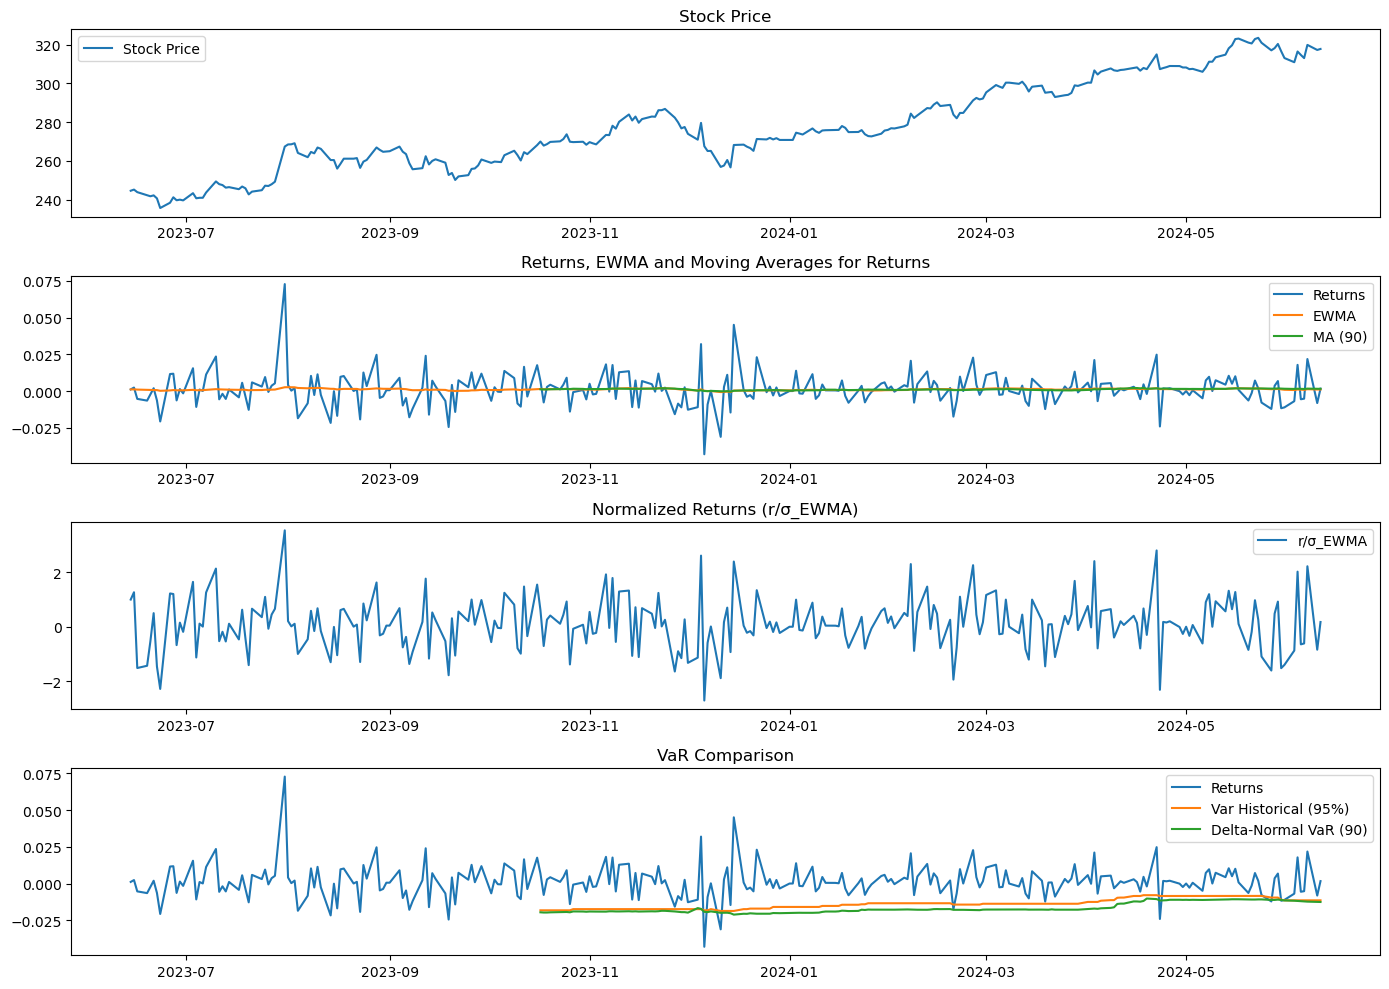


Результаты проверки на нарушения (violations) и их p-значения:

Всего наблюдений: 260
Ожидаемые нарушения (5%): 13.00
Нарушения, Delta-Normal VaR: 5
p-значение, Delta-Normal VaR: 0.9968
Нарушения, Filtered VaR, EWMA: 75
p-значение, Filtered VaR, EWMA: 0.0000
Нарушения, Historical VaR: 6
p-значение, Historical VaR: 0.9906


In [9]:
stock_data, results, ma_window = perform_var_analysis(SECID, START_DATE, END_DATE, MA_WINDOW)

plot_var_analysis(stock_data, SECID, ma_window)

# Вывод результатов
print("\nРезультаты проверки на нарушения (violations) и их p-значения:\n")
print(f"Всего наблюдений: {results['Observations']}")
print(f"Ожидаемые нарушения (5%): {results['Expected Violations (5%)']:.2f}")
print(f"Нарушения, Delta-Normal VaR: {results['Violations, Delta-Normal VaR']}")
print(f"p-значение, Delta-Normal VaR: {results['p-value, Delta-Normal VaR']:.4f}")
print(f"Нарушения, Filtered VaR, EWMA: {results['Violations, Filtered VaR, EWMA']}")
print(f"p-значение, Filtered VaR, EWMA: {results['p-value, Filtered VaR, EWMA']:.4f}")
print(f"Нарушения, Historical VaR: {results['Violations, Historical VaR']}")
print(f"p-значение, Historical VaR: {results['p-value, Historical VaR']:.4f}")